In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import findspark

import pyspark

from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark import SparkContext

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import plot

from sklearn import model_selection, linear_model, preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from scipy.stats import norm,skewnorm,pearsonr

from bs4 import BeautifulSoup, SoupStrainer
import requests
import time

import pickle
import os
import time
import nltk

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
import seaborn as sns
from PIL import *
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import networkx as nx

import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

In [3]:
df = pd.read_csv("youtube-new/USvideos.csv")

In [4]:
#Looking some information of the data
print(df.shape)
print(df.nunique())

(40949, 16)
video_id                   6351
trending_date               205
title                      6455
channel_title              2207
category_id                  16
publish_time               6269
tags                       6055
views                     40478
likes                     29850
dislikes                   8516
comment_count             13773
thumbnail_link             6352
comments_disabled             2
ratings_disabled              2
video_error_or_removed        2
description                6901
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


In [6]:
df.category_id.nunique()

16

In [7]:
df.head(30)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,1434,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,False,False,False,Using the iPhone for the past two weeks -- her...
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,1970,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,False,False,False,Embattled Alabama Senate candidate Roy Moore (...
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,3432,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,False,False,False,Ice Cream Pint Combination Lock - http://amzn....
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,340,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th..."
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,2368,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,False,False,False,"For now, at least, we have better things to wo..."


In [8]:
liste_category  = ['Film and Animation', 'Cars and Vehicles','Music','Pets and Animals','Sport','Travel and Events','Gaming','People and Blogs','Comedy','Entertainment','News and Politics','How to and Style','Education','Science and Technology','Non Profits and Activism']

In [9]:
df['category_name'] = np.nan

df.loc[(df["category_id"] == 1),"category_name"] = 'Film and Animation'
df.loc[(df["category_id"] == 2),"category_name"] = 'Cars and Vehicles'
df.loc[(df["category_id"] == 10),"category_name"] = 'Music'
df.loc[(df["category_id"] == 15),"category_name"] = 'Pets and Animals'
df.loc[(df["category_id"] == 17),"category_name"] = 'Sport'
df.loc[(df["category_id"] == 19),"category_name"] = 'Travel and Events'
df.loc[(df["category_id"] == 20),"category_name"] = 'Gaming'
df.loc[(df["category_id"] == 22),"category_name"] = 'People and Blogs'
df.loc[(df["category_id"] == 23),"category_name"] = 'Comedy'
df.loc[(df["category_id"] == 24),"category_name"] = 'Entertainment'
df.loc[(df["category_id"] == 25),"category_name"] = 'News and Politics'
df.loc[(df["category_id"] == 26),"category_name"] = 'How to and Style'
df.loc[(df["category_id"] == 27),"category_name"] = 'Education'
df.loc[(df["category_id"] == 28),"category_name"] = 'Science and Technology'
df.loc[(df["category_id"] == 29),"category_name"] = 'Non Profits and Activism'

In [10]:
eng_stopwords = set(stopwords.words("english"))

Text(0, 0.5, 'Count')

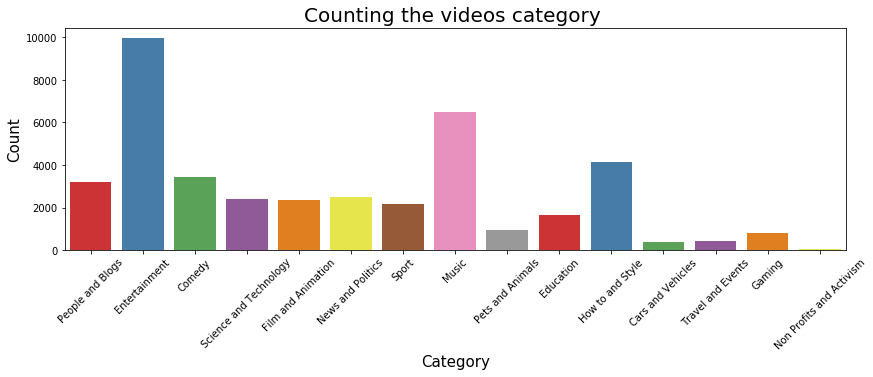

In [11]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('category_name', data=df, palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting the videos category ", fontsize=20)
g.set_xlabel("Category", fontsize=15)
g.set_ylabel("Count", fontsize=15)

In [12]:
df['title'] = df['title'].astype('str')

In [13]:
title_corpus = ' '.join(df['title'])

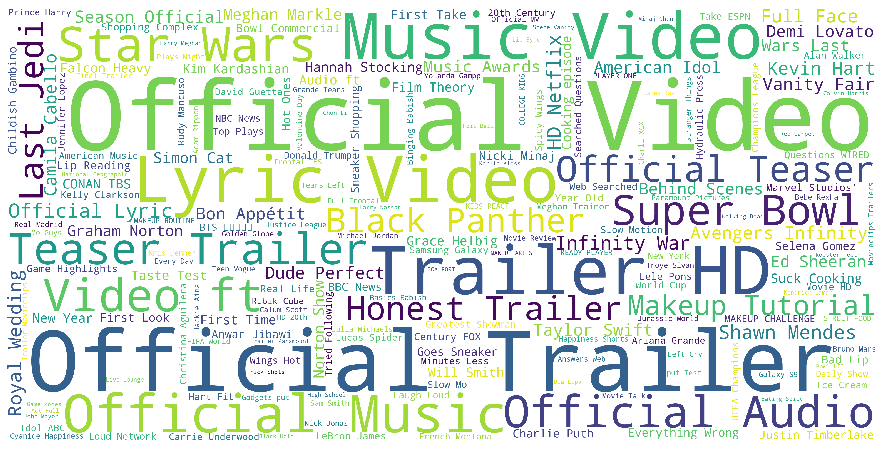

In [14]:
# For the full corpus
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [15]:
#For each category
title_corpus1 = ' '.join(df.loc[(df["category_id"] == 1)]['title'])
title_corpus2 = ' '.join(df.loc[(df["category_id"] == 2)]['title'])
title_corpus3 = ' '.join(df.loc[(df["category_id"] == 10)]['title'])
title_corpus4 = ' '.join(df.loc[(df["category_id"] == 15)]['title'])
title_corpus5 = ' '.join(df.loc[(df["category_id"] == 17)]['title'])
title_corpus6 = ' '.join(df.loc[(df["category_id"] == 19)]['title'])
title_corpus7 = ' '.join(df.loc[(df["category_id"] == 20)]['title'])
title_corpus8 = ' '.join(df.loc[(df["category_id"] == 22)]['title'])
title_corpus9 = ' '.join(df.loc[(df["category_id"] == 23)]['title'])
title_corpus10 = ' '.join(df.loc[(df["category_id"] == 24)]['title'])
title_corpus11= ' '.join(df.loc[(df["category_id"] == 25)]['title'])
title_corpus12 = ' '.join(df.loc[(df["category_id"] == 26)]['title'])
title_corpus13 = ' '.join(df.loc[(df["category_id"] == 27)]['title'])
title_corpus14 = ' '.join(df.loc[(df["category_id"] == 28)]['title'])
title_corpus15 = ' '.join(df.loc[(df["category_id"] == 29)]['title'])


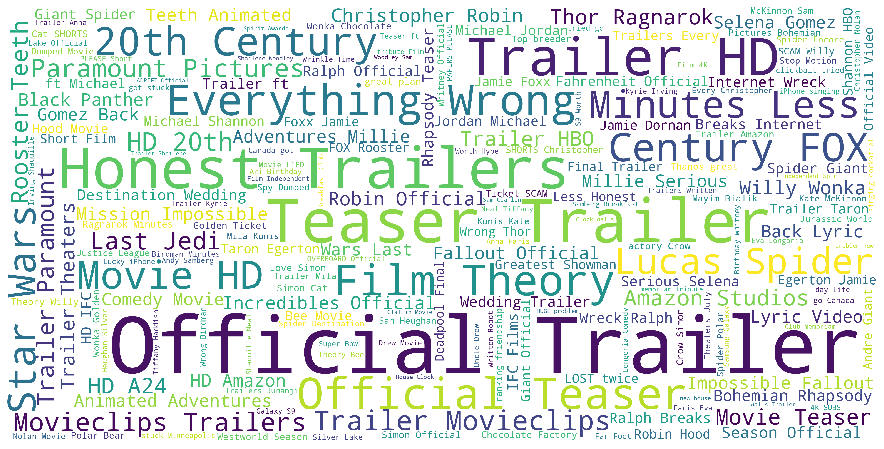

In [16]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus1)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [22]:
# Creat nice CSV for project
liste_category  = ['Film and Animation', 'Cars and Vehicles','Music','Pets and Animals','Sport','Travel and Events','Gaming','People and Blogs','Comedy','Entertainment','News and Politics','How to and Style','Education','Science and Technology','Non Profits and Activism']
data = pd.DataFrame(np.zeros((23, 15)),columns=liste_category,index= list(range(1,24))  )
data.index.name = "Size"
df_1 = df.copy()
df_1 = df_1[["count_word",'category_name']]
for i in liste_category : 
    data[i] = df_1[df_1["category_name"]== i]["count_word"].value_counts().sort_index()
data["ALL"] = df_1 ["count_word"].value_counts().sort_index()
data.fillna(0, inplace = True)
data

,Film and Animation,Cars and Vehicles,Music,Pets and Animals,Sport,Travel and Events,Gaming,People and Blogs,Comedy,Entertainment,News and Politics,How to and Style,Education,Science and Technology,Non Profits and Activism,ALL
Size,,,,,,,,,,,,,,,,
1,25.0,0.0,11.0,0.0,15.0,0.0,0.0,11.0,39.0,15.0,0.0,0.0,22.0,14.0,0.0,152.0
2,14.0,9.0,38.0,27.0,5.0,0.0,22.0,58.0,42.0,92.0,0.0,27.0,17.0,106.0,0.0,457.0
3,106.0,0.0,102.0,55.0,68.0,9.0,57.0,178.0,254.0,243.0,7.0,99.0,63.0,140.0,0.0,1381.0
4,188.0,24.0,342.0,75.0,46.0,40.0,63.0,290.0,328.0,417.0,22.0,224.0,106.0,225.0,8.0,2398.0
5,247.0,30.0,707.0,103.0,63.0,19.0,95.0,432.0,429.0,808.0,138.0,251.0,164.0,379.0,0.0,3865.0
6,255.0,42.0,897.0,89.0,175.0,31.0,100.0,337.0,432.0,912.0,250.0,423.0,226.0,392.0,13.0,4574.0
7,192.0,35.0,890.0,123.0,178.0,42.0,81.0,499.0,441.0,858.0,288.0,450.0,265.0,329.0,11.0,4682.0
8,286.0,45.0,900.0,93.0,134.0,28.0,85.0,328.0,365.0,1267.0,312.0,495.0,236.0,197.0,5.0,4776.0
9,276.0,74.0,842.0,75.0,272.0,54.0,61.0,304.0,287.0,1012.0,267.0,561.0,203.0,185.0,3.0,4476.0


In [18]:
#Word count in each title:
df['count_word']=df["title"].apply(lambda x: len(str(x).split()))
#nbr caracter in each title:
df['nbr_caracter']=df["title"].apply(lambda x: len(str(x)))

#mean size title per category
category_words = df.groupby(["category_name"])['count_word'].mean().to_frame()
category_size = df.groupby(["category_name"])['nbr_caracter'].mean().to_frame()
category_words["category"] = category_words.index.values.tolist()
category_size["category"] = category_size.index.values.tolist()

category_words = category_words.sort_values(['count_word'],ascending=False).reset_index(drop=True)
category_size = category_size.sort_values(['nbr_caracter'],ascending=False).reset_index(drop=True)

Text(0, 0.5, 'Count')

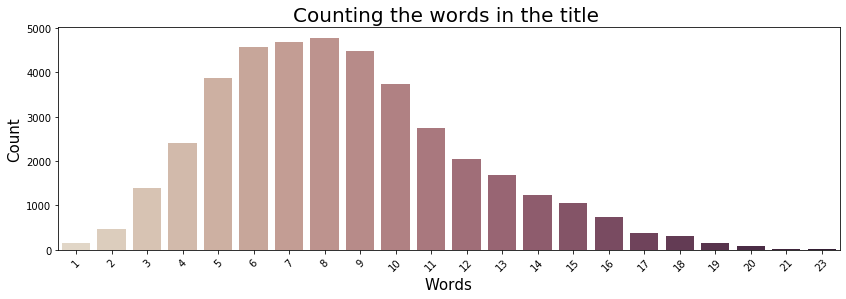

In [19]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('count_word', data=df,palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting the words in the title ", fontsize=20)
g.set_xlabel("Words", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

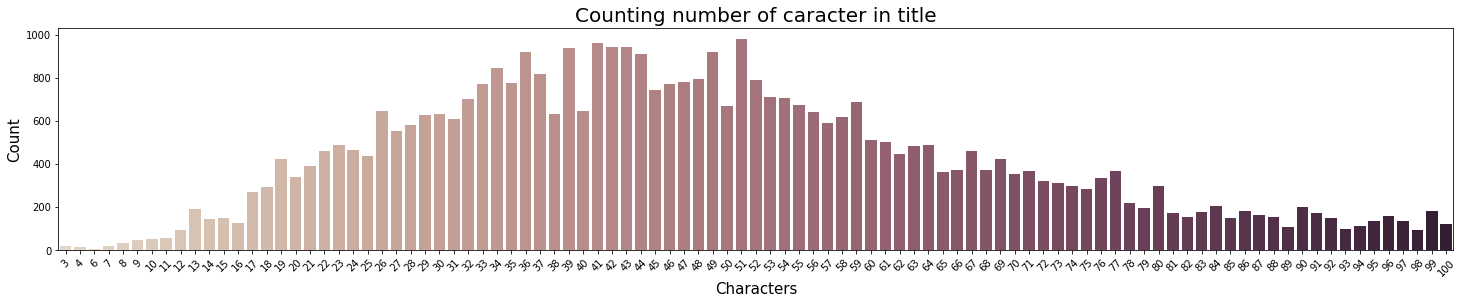

In [20]:
plt.figure(figsize = (25,9))
plt.subplot(211)
g = sns.countplot('nbr_caracter', data=df,palette="ch:.25")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Counting number of caracter in title", fontsize=20)
g.set_xlabel("Characters", fontsize=15)
g.set_ylabel("Count", fontsize=15)

Text(0, 0.5, 'mean size')

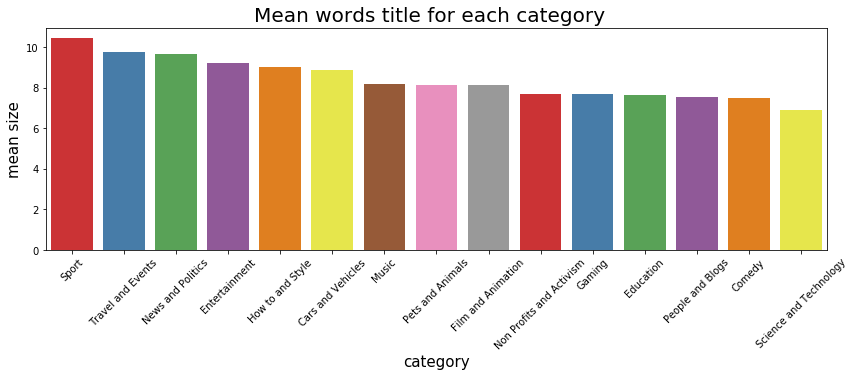

In [155]:
plt.figure(figsize = (14,9))
plt.subplot(211)

g =sns.barplot(x=category_words["category"], y=category_words['count_word'], palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Mean words title for each category  ", fontsize=20)
g.set_xlabel("category", fontsize=15)
g.set_ylabel("mean size", fontsize=15)

Text(0, 0.5, 'mean size')

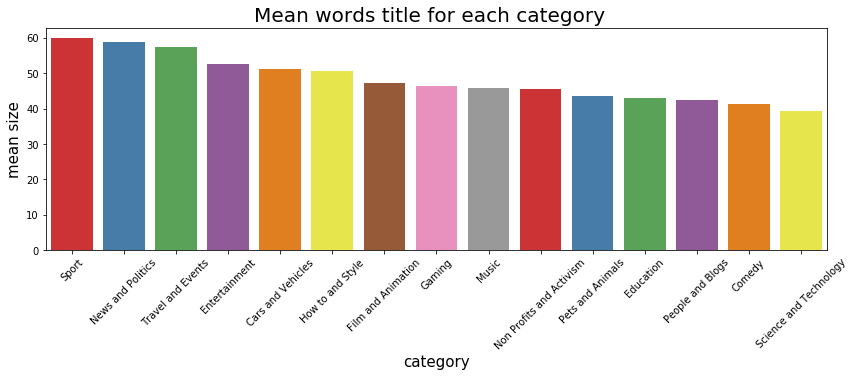

In [156]:
plt.figure(figsize = (14,9))
plt.subplot(211)

g =sns.barplot(x=category_size["category"], y=category_size['nbr_caracter'], palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Mean words title for each category  ", fontsize=20)
g.set_xlabel("category", fontsize=15)
g.set_ylabel("mean size", fontsize=15)

In [157]:
# Creation of the fucntion
analyzer = SentimentIntensityAnalyzer()
total_sent = []

In [158]:
[total_sent.append(analyzer.polarity_scores(test)['compound']) for test in df["title"].values] #mask
print("End")

End


Text(0, 0.5, 'Number of sentences')

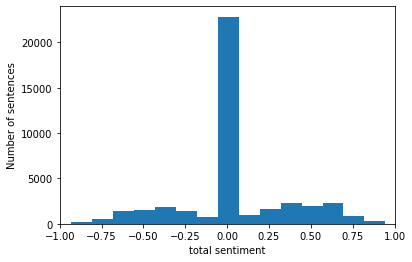

In [159]:
plt.hist(total_sent,bins=15)
plt.xlim([-1,1])
plt.xlabel('total sentiment')
plt.ylabel('Number of sentences')

In [160]:
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,count_word,nbr_caracter
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People and Blogs,7,34
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",Entertainment,10,62
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,Comedy,10,53
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...,Entertainment,5,32
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...,Entertainment,5,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,18.14.06,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18T13:00:04.000Z,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals,Pets and Animals,6,28
40945,1h7KV2sjUWY,18.14.06,True Facts : Ant Mutualism,zefrank1,22,2018-05-18T01:00:06.000Z,[none],1064798,60008,382,3936,https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg,False,False,False,NaN,People and Blogs,5,26
40946,D6Oy4LfoqsU,18.14.06,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18T17:34:22.000Z,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...,Entertainment,14,84
40947,oV0zkMe1K8s,18.14.06,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17T17:00:04.000Z,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...,Film and Animation,6,35


In [211]:


from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
def my_function(df):
    
    top_N = 100
    #convert list of list into text
    #a=''.join(str(r) for v in df_usa['title'] for r in v)

    a = df['title'].str.lower().str.cat(sep=' ')

    # removes punctuation,numbers and returns list of words
    b = re.sub('[^A-Za-z]+', ' ', a)

    #remove all the stopwords from the text
    stop_words = list(get_stop_words('en'))         
    nltk_words = list(stopwords.words('english'))   
    stop_words.extend(nltk_words)

    word_tokens = word_tokenize(b)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    # Remove characters which have length less than 2  
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]

    # Remove numbers
     
    cleaned_data_title  = [word for word in without_single_chr if not word.isnumeric()]    
    
    bgs = nltk.trigrams(cleaned_data_title)

    #compute frequency distribution for all the bigrams in the text
    fdist = nltk.FreqDist(bgs)
    trigram =pd.DataFrame(list(fdist.items()), columns = ["Word","Frequency"])

    return trigram.sort_values(['Frequency'],ascending=False).reset_index(drop=True).iloc[0:20] 
    



In [212]:
def Plot_network(trigram):
    g = nx.from_pandas_edgelist(trigram,source='category',target='Word')
    print(nx.info(g))
    plt.figure(figsize=(20, 20))
    cmap = plt.cm.coolwarm
    colors = [n for n in range(len(g.nodes()))]
    #k = 0.0319
    k = 0.04
    pos=nx.spring_layout(g, k=k)
    nx.draw_networkx(g,pos, node_size=trigram['Frequency'].values*20, cmap = cmap, 
                     node_color=colors, edge_color='grey', font_size=15, width=2, alpha=1)
    plt.title("Network diagram of Top 20 Trigrams w/o Stopwords removed attributed to each Author",
             fontsize=18)
    plt.show()

In [213]:
df.loc[(df["category_id"] == 1),"category_name"] = 'Film and Animation'
df.loc[(df["category_id"] == 2),"category_name"] = 'Cars and Vehicles'
df.loc[(df["category_id"] == 10),"category_name"] = 'Music'
df.loc[(df["category_id"] == 15),"category_name"] = 'Pets and Animals'
df.loc[(df["category_id"] == 17),"category_name"] = 'Sport'
df.loc[(df["category_id"] == 19),"category_name"] = 'Travel and Events'
df.loc[(df["category_id"] == 20),"category_name"] = 'Gaming'
df.loc[(df["category_id"] == 22),"category_name"] = 'People and Blogs'
df.loc[(df["category_id"] == 23),"category_name"] = 'Comedy'
df.loc[(df["category_id"] == 24),"category_name"] = 'Entertainment'
df.loc[(df["category_id"] == 25),"category_name"] = 'News and Politics'
df.loc[(df["category_id"] == 26),"category_name"] = 'How to and Style'
df.loc[(df["category_id"] == 27),"category_name"] = 'Education'
df.loc[(df["category_id"] == 28),"category_name"] = 'Science and Technology'
df.loc[(df["category_id"] == 29),"category_name"] = 'Non Profits and Activism'

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 20
Average degree:   1.9048


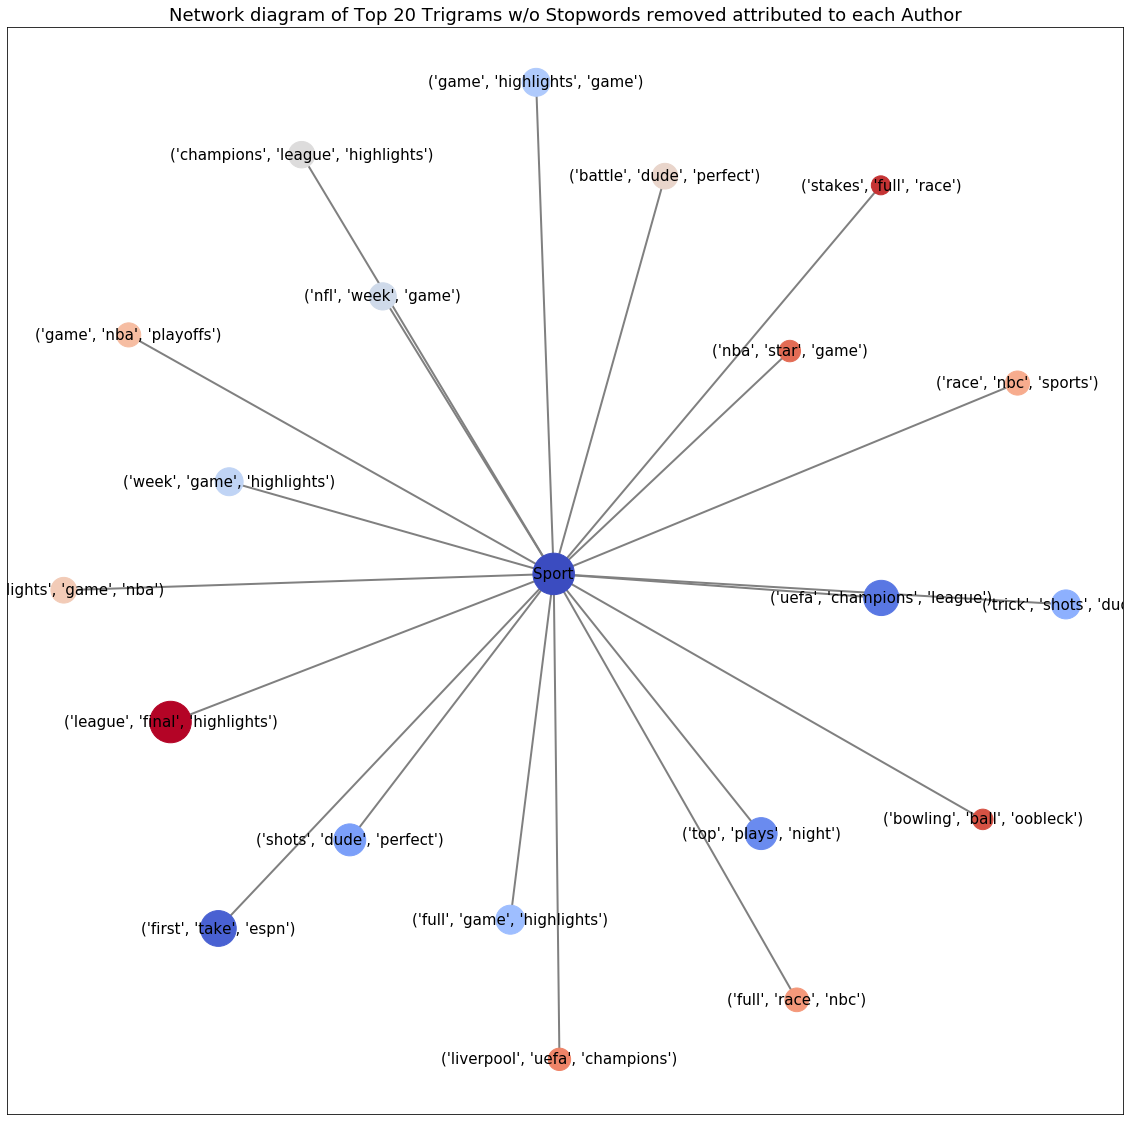

In [214]:
trigram = my_function(df[df.category_name=="Sport"])
trigram["category"] =  "Sport"
trigram2 = my_function(df[df.category_name=="Entertainment"])
trigram2["category"] =  "Entertainment"
trigram3 = my_function(df[df.category_name=="Music"])
trigram3["category"] =  "Music"
trigram4 = my_function(df[df.category_name=="Film and Animation"])
trigram4["category"] =  "Film and Animation"
trigram5 = my_function(df[df.category_name=="Cars and Vehicles"])
trigram5["category"] =  "Cars and Vehicles"
trigram6 = my_function(df[df.category_name=="Pets and Animals"])
trigram6["category"] =  "Pets and Animals"

trigram_df = pd.concat([trigram ,trigram2,trigram3,trigram4,trigram5,trigram6])
Plot_network (trigram)               

In [192]:
trigram

,Word,Frequency,category
0,"(dude, perfect)",130,Sport
1,"(first, take)",100,Sport
2,"(game, highlights)",91,Sport
3,"(lebron, james)",87,Sport
4,"(take, espn)",86,Sport
5,"(top, plays)",76,Sport
6,"(uefa, champions)",64,Sport
7,"(champions, league)",64,Sport
8,"(plays, night)",62,Sport
9,"(trick, shots)",51,Sport


Text(0, 0.5, 'Frequency')

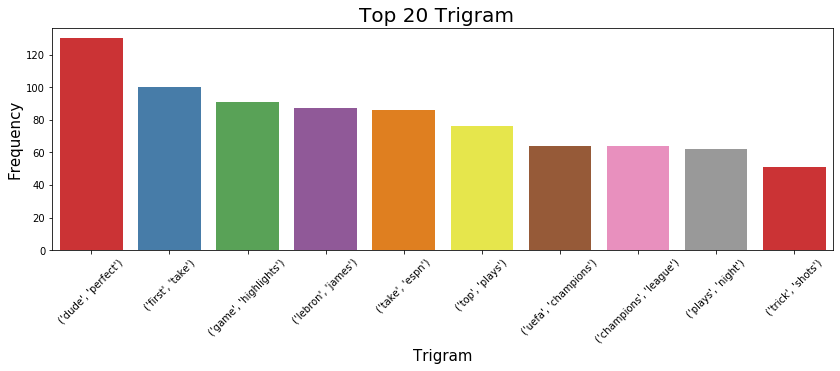

In [193]:
plt.figure(figsize = (14,9))
plt.subplot(211)

g =sns.barplot(x=trigram["Word"], y=trigram['Frequency'], palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Top 20 Trigram  ", fontsize=20)
g.set_xlabel("Trigram", fontsize=15)
g.set_ylabel("Frequency", fontsize=15)

# Analyse for each class

In [167]:
df1 = df[df.category_name=="Sport"].copy()
df1

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,count_word,nbr_caracter
10,9wRQljFNDW8,17.14.11,Dion Lewis' 103-Yd Kick Return TD vs. Denver! ...,NFL,17,2017-11-13T02:05:26.000Z,"NFL|""Football""|""offense""|""defense""|""afc""|""nfc""...",81377,655,25,177,https://i.ytimg.com/vi/9wRQljFNDW8/default.jpg,False,False,False,New England Patriots returner Dion Lewis blast...,Sport,16,86
42,NZFhMSgbKKM,17.14.11,Dennis Smith Jr. and LeBron James go back and ...,Ben Rohrbach,17,2017-11-13T15:11:00.000Z,[none],945,7,5,8,https://i.ytimg.com/vi/NZFhMSgbKKM/default.jpg,False,False,False,NaN,Sport,10,51
47,sbcbvuitiTc,17.14.11,Stephon Marbury and Jimmer Fredette fight in C...,NBA Highlights · YouTube,17,2017-11-10T18:23:05.000Z,"NBA|""Basketball""|""Sports""",956169,2017,2425,1447,https://i.ytimg.com/vi/sbcbvuitiTc/default.jpg,False,False,False,NaN,Sport,8,50
48,zNqCVTs38nU,17.14.11,Heidelberg's nifty hook-and-lateral to the lef...,D3sports.com,17,2017-11-13T02:15:30.000Z,"D3sports|""NCAA Division III""|""D3sports.com""|""D...",4569,35,18,19,https://i.ytimg.com/vi/zNqCVTs38nU/default.jpg,False,False,False,Tyler Stoyle hits Demetrius Magee for a short ...,Sport,7,54
52,069D0NmW39o,17.14.11,"Wildest Superstar distractions: WWE Top 10, No...",WWE,17,2017-11-11T15:00:00.000Z,"wwe|""world wrestling entertainment""|""wrestling...",1044813,15397,838,1100,https://i.ytimg.com/vi/069D0NmW39o/default.jpg,False,False,False,A timely distraction can create real trouble f...,Sport,9,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40761,JGm9Y_hFqNk,18.14.06,First Take reacts: Kyrie Irving says contract ...,ESPN,17,2018-06-13T15:06:08.000Z,"espn|""espn live""|""boston celtics""|""kyrie irvin...",812832,7701,320,2505,https://i.ytimg.com/vi/JGm9Y_hFqNk/default.jpg,False,False,False,First Take's Stephen A. Smith and Max Kellerma...,Sport,16,94
40787,L4pkD78oKSo,18.14.06,Belmont Stakes 2018 I FULL RACE I Justify's Pu...,NBC Sports,17,2018-06-09T23:10:07.000Z,"Horse racing|""horses""|""horse""|""racing""|""Triple...",1146392,6789,1038,2081,https://i.ytimg.com/vi/L4pkD78oKSo/default.jpg,False,False,False,Watch as Justify attempts to become only the 1...,Sport,16,84
40828,v-dfygYIfLs,18.14.06,Old School Trick Shots | Dude Perfect,Dude Perfect,17,2018-06-04T21:55:13.000Z,"dude perfect|""dude perfect stereotypes""|""dude ...",13782417,441898,9947,38539,https://i.ytimg.com/vi/v-dfygYIfLs/default.jpg,False,False,False,It’s time to look old! Special thanks to the U...,Sport,7,37
40878,tsM6kq-7nmw,18.14.06,Does LeBron need a 4th title to pass Jordan as...,Skip and Shannon: UNDISPUTED,17,2018-05-30T17:01:39.000Z,"fox|""fox sports""|""fs1""|""fox sports 1""|""undispu...",787517,6420,1940,8124,https://i.ytimg.com/vi/tsM6kq-7nmw/default.jpg,False,False,False,"Rob Parker joins Skip Bayless, Shannon Sharpe ...",Sport,16,75


In [177]:

df['likes_log'] = np.log(df['likes'] + 1)
df['views_log'] = np.log(df['views'] + 1)
df['dislikes_log'] = np.log(df['dislikes'] + 1)
df['comment_log'] = np.log(df['comment_count'] + 1)

df['like_rate'] =  df ['likes'] / df['views'] * 100
df['dislike_rate'] =  df['dislikes'] / df['views'] * 100
df['comment_rate'] =  df['comment_count'] / df['views'] * 100




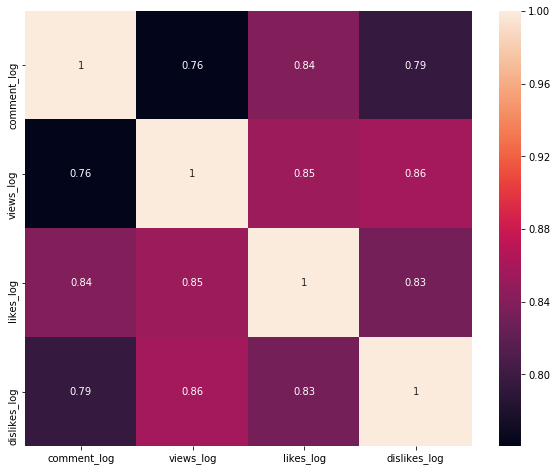

In [169]:







plt.figure(figsize = (10,8))

#Let's verify the correlation of each value
sns.heatmap(df[['comment_log',
         'views_log','likes_log','dislikes_log', "category_name"]].corr(), annot=True)
plt.show()




In [170]:
def over_time(youtube, var):
    averages = youtube[youtube["dislikes"] != 0].groupby("trending_date").mean()
    plt.plot(averages.index.values, averages[var])
    plt.xticks(rotation = 90)
    plt.xlabel("Date")
    plt.ylabel(f"Average {var}")
    plt.title(f"Average {var} Over Time (11/14/17 - 6/14/18)")
    plt.show()

In [171]:
over_time(youtube, "views")

NameError: name 'youtube' is not defined

In [172]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS



In [173]:
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

Category Name count
5     6681
2     6207
12    6182
3     6175
1     5502
Name: month, dtype: int64


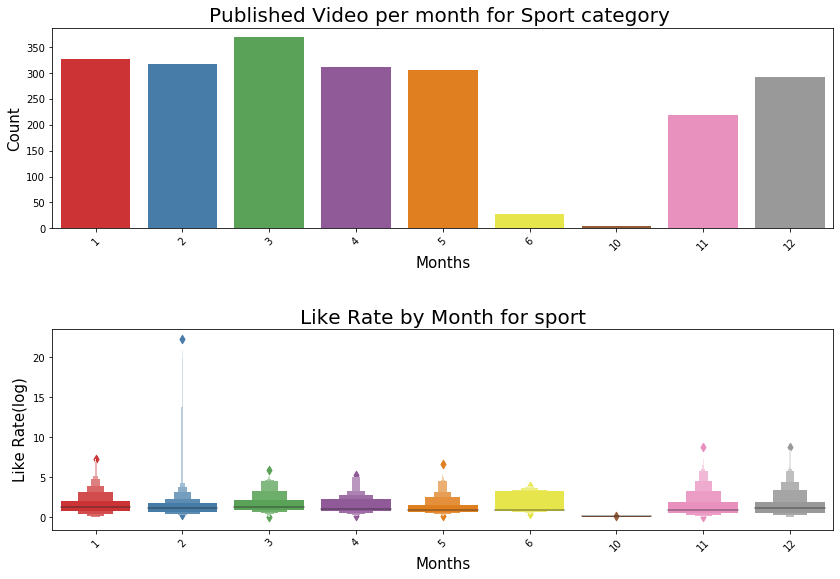

In [179]:
df['month'] = df['publish_time'].dt.month

print("Category Name count")
print(df['month'].value_counts()[:5])

df1 = df[df.category_name=="Sport"]

month_publication(df1)

In [180]:
def month_publication(df):
    plt.figure(figsize = (14,9))

    plt.subplot(211)
    g = sns.countplot('month', data=df, palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("Published Video per month for Sport category ", fontsize=20)
    g.set_xlabel("Months", fontsize=15)
    g.set_ylabel("Count", fontsize=15)

    plt.subplot(212)
    g1 = sns.lvplot(x='month', y='like_rate', data=df, palette="Set1")
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title("Like Rate by Month for sport", fontsize=20)
    g1.set_xlabel("Months", fontsize=15)
    g1.set_ylabel("Like Rate(log)", fontsize=15)

    plt.subplots_adjust(hspace = 0.5, top = 0.9)

    plt.show()

In [181]:
# separates date and time into two columns from 'publish_time' column
df.insert(4, 'publish_date', df['publish_time'].dt.date)
df['publish_time'] = df['publish_time'].dt.time
df[['hour','min','sec']] = df['publish_time'].astype(str).str.split(':', expand=True).astype(int)

In [184]:
def hours(df):

    plt.figure(figsize = (14,9))

    plt.subplot(211)
    g = sns.countplot('hour', data=df, palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("What is the best publication time for sport video", fontsize=20)
    g.set_xlabel("Hours", fontsize=15)
    g.set_ylabel("Count", fontsize=15)

    plt.subplot(212)
    g1 = sns.lvplot(x='hour', y='like_rate', data=df, palette="Set1")
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title("Like Rate by Hour", fontsize=20)
    g1.set_xlabel("Hours", fontsize=15)
    g1.set_ylabel("Like Rate(log)", fontsize=15)

    plt.subplots_adjust(hspace = 0.5, top = 0.9)

    plt.show()

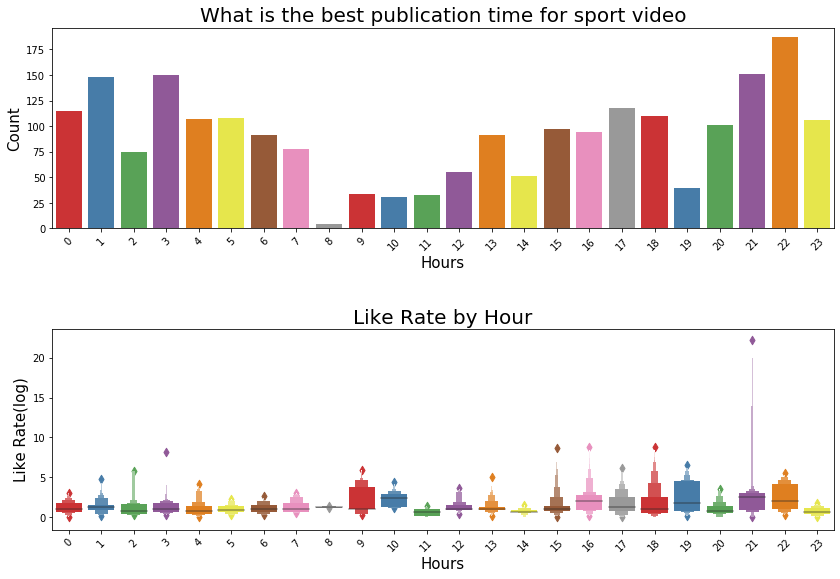

In [185]:
df1 = df[df.category_name=="Sport"]
hours(df1 )